# Conditional image synthesis with AC-GANs (Auxiliary Classifier GANs)


## 0. Imports

In [2]:
from __future__ import print_function, division

import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Conv2D, UpSampling2D, concatenate, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

from keras.datasets import mnist, fashion_mnist, cifar10
import tensorflow_datasets as tfds

from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Activation
from keras import backend as K
from tensorflow.keras.utils import get_custom_objects

import pandas as pd

## 1. Utils (plots and metrics)

### 1.1 Plots

In [4]:
#Show the Generator-Descriminator loss for every epoch
def plot_gan_losses(g_loss, d_loss):
    plt.plot(g_loss)
    plt.plot(d_loss)
    plt.title('GAN Loss evolution')
    plt.ylabel('')
    plt.xlabel('epoch')
    plt.legend(['Generator', 'Discriminator'], loc='upper left')
    plt.show()

In [5]:
def plot_n_closest(img_smp, id_label_sample, X_train, N_closest, fig_size=(8, 3)):
    #get the images that belong to id_label_sample
    idx_lab = np.where(y_train==id_label_sample)
    X_lab = (X_train[idx_lab, :, :].astype(np.float32) / 255)[0, :, :, :]

    #apply the norm between X_lab and the sampled image across all images
    L1d = np.sum(np.apply_along_axis(np.linalg.norm, -1, X_lab - img_smp, ord=1), axis=1)
    idx_l1_sort = L1d.argsort()
    #plt.imshow(X_lab[idx_l1_sort[0], :, :], cmap='gray')
    fig, axs = plt.subplots(1, N_closest, figsize=fig_size)
    for i in range(N_closest):
        axs[i].imshow(X_lab[idx_l1_sort[i], :, :], cmap='gray')
        axs[i].axis('off')
    plt.show()

### 1.3 Metrics (keras)

#### 1.3.1 Inception Score

In [6]:
from math import floor
from numpy import ones, expand_dims, log, mean, std, exp, asarray

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets import cifar10
from skimage.transform import resize

from random import shuffle


# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return np.asarray(images_list)


# assumes images have any shape and pixels in [0,255]
def calculate_inception_score(images, n_split=10, eps=1E-16):
	# load inception v3 model
	model = InceptionV3()
	# enumerate splits of images/predictions
	scores = list()
	n_part = np.floor(images.shape[0] / n_split)
	for i in range(n_split):
		# retrieve images
		ix_start, ix_end = int(i * n_part), int((i+1) * n_part)

		subset = images[ix_start:ix_end]
		subset = subset.astype('float32')

		# scale images to the required size
		subset = scale_images(subset, (299,299,3))

		# pre-process images, scale to [-1,1]
		subset = preprocess_input(subset)

		# predict p(y|x)
		p_yx = model.predict(subset)
		# calculate p(y)
		p_y = np.expand_dims(p_yx.mean(axis=0), 0)

		# calculate KL divergence using log probabilities
		kl_d = p_yx * (np.log(p_yx + eps) - np.log(p_y + eps))

		# sum over classes
		sum_kl_d = kl_d.sum(axis=1)
		# average over images
		avg_kl_d = np.mean(sum_kl_d)
		# undo the log
		is_score = np.exp(avg_kl_d)

		# store
		scores.append(is_score)

	# average across images
	is_avg, is_std = mean(scores), std(scores)
	return is_avg, is_std

In [ ]:
# load cifar10 images
(images, _), (_, _) = cifar10.load_data()
# shuffle images
shuffle(images)
print('loaded', images.shape)
# calculate inception score
is_avg, is_std = calculate_inception_score(images)
print('score', is_avg, is_std)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
loaded (50000, 32, 32, 3)
96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


#### 1.3.3 Inception Score (last try)

In [ ]:
!git clone https://github.com/hvy/chainer-inception-score/tree/08f8b4eab533df6bdf4ae3b892bee6fb71039f1b

!python download.py --outfile inception_score.model

In [ ]:
import numpy as np
from chainer import serializers, datasets
from inception_score import Inception, inception_score

model = Inception()
serializers.load_hdf5('inception_score.model', model)

train, test = datasets.get_cifar10(ndim=3, withlabel=False, scale=255.0)
mean, std = inception_score(model, np.concatenate(train, test))

print('Inception score mean:', mean)
print('Inception score std:', std)

## 2. introduction : Fashion_MNIST

### 2.1 implementation

In [ ]:
class AcGan_fashion():
  def __init__(self, nb_rows, nb_columns, nb_channels, nb_classes, noise_dim=100):
    self.input_shape = (nb_rows, nb_columns, nb_channels)
    self.nb_classes = nb_classes
    self.noise_dim = noise_dim
    self.discriminator = Sequential()
    self.generator = Sequential()
    self.model = None
    self.optimizer = Adam(0.0002, 0.5)
    self.losses = ['binary_crossentropy', 'sparse_categorical_crossentropy']


  def instanciate_discriminator(self) :
    self.discriminator.add(Conv2D(16, kernel_size=3, strides=2, input_shape=self.input_shape, padding="same"))
    self.discriminator.add(LeakyReLU(alpha=0.2))
    self.discriminator.add(Dropout(0.25))

    self.discriminator.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
    self.discriminator.add(ZeroPadding2D(padding=((0,1),(0,1))))
    self.discriminator.add(LeakyReLU(alpha=0.2))
    self.discriminator.add(Dropout(0.25))
    self.discriminator.add(BatchNormalization(momentum=0.8))

    self.discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    self.discriminator.add(LeakyReLU(alpha=0.2))
    self.discriminator.add(Dropout(0.25))
    self.discriminator.add(BatchNormalization(momentum=0.8))

    self.discriminator.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
    self.discriminator.add(LeakyReLU(alpha=0.2))
    self.discriminator.add(Dropout(0.25))

    self.discriminator.add(Flatten())

    self.discriminator.summary()

    # Extract feature representation
    img_real = Input(shape=self.input_shape)
    features = self.discriminator(img_real)

    # Determine validity and label of the image
    validity = Dense(1, activation="sigmoid")(features)
    label = Dense(self.nb_classes+1, activation="softmax")(features)

    self.discriminator = Model(img_real, [validity, label])
    self.discriminator.compile(loss=self.losses,
      optimizer=self.optimizer,
      metrics=['accuracy'])



  def instanciate_generator(self):
    self.generator.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.noise_dim))
    self.generator.add(Reshape((7, 7, 128)))
    self.generator.add(BatchNormalization(momentum=0.8))
    self.generator.add(UpSampling2D())

    self.generator.add(Conv2D(128, kernel_size=3, padding="same"))
    self.generator.add(Activation("relu"))
    self.generator.add(BatchNormalization(momentum=0.8))
    self.generator.add(UpSampling2D())

    self.generator.add(Conv2D(64, kernel_size=3, padding="same"))
    self.generator.add(Activation("relu"))
    self.generator.add(BatchNormalization(momentum=0.8))

    self.generator.add(Conv2D(self.input_shape[2], kernel_size=3, padding='same'))
    self.generator.add(Activation("tanh"))

    self.generator.summary()

    noise = Input(shape=(self.noise_dim,))
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Flatten()(Embedding(self.nb_classes, self.noise_dim)(label))

    model_input = multiply([noise, label_embedding])
    img_gen = self.generator(model_input)

    self.generator = Model([noise, label], img_gen)



  def instanciate_combined_model(self):
    # The generator takes noise and the target label as input and generates the corresponding digit of that label
    noise = Input(shape=(self.noise_dim,))
    label = Input(shape=(1,), dtype='int32')
    img_gen = self.generator([noise, label])

    # For the combined model we will only train the generator
    self.discriminator.trainable = False

    # The discriminator takes generated image as input and determines validity and the label of that image
    valid, target_label = self.discriminator(img_gen)

    # The combined model  (stacked generator and discriminator) trains the generator to fool the discriminator
    self.model = Model([noise, label], [valid, target_label])
    self.model.compile(loss=self.losses,
        optimizer=self.optimizer)



  def train(self, X_train, y_train, epochs, batch_size=128, sample_interval=50):
    # Configure inputs
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)
    y_train = y_train.reshape(-1, 1)

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    # Loss output
    g_loss_epochs = np.zeros((epochs, 1))
    d_loss_epochs = np.zeros((epochs, 1))

    for epoch in range(epochs):
        # ---------------------
        #  Train Discriminator
        # ---------------------
        # Select a random batch of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Sample noise as generator input
        noise = np.random.normal(0, 1, (batch_size, self.noise_dim))

        # The labels of the digits that the generator tries to create an
        # image representation of
        sampled_labels = np.random.randint(0, 10, (batch_size, 1))

        # Generate a half batch of new images
        gen_imgs = self.generator.predict([noise, sampled_labels])

        # Image labels. 0-9 if image is valid or 10 if it is generated (fake)
        img_labels = y_train[idx]
        fake_labels = 10 * np.ones(img_labels.shape)

        # Train the discriminator
        d_loss_real = self.discriminator.train_on_batch(imgs, [valid, img_labels])
        d_loss_fake = self.discriminator.train_on_batch(gen_imgs, [fake, fake_labels])
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------
        g_loss = self.model.train_on_batch([noise, sampled_labels], [valid, sampled_labels])

        #show the final losses
        g_loss_epochs[epoch] = g_loss[0]
        d_loss_epochs[epoch] = d_loss[0]

        # If at save interval => save generated image samples
        if epoch % sample_interval == 0:
            # Plot the progress
            print ("Epoch: %d [D loss: %f, acc.: %.2f%%, op_acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[3], 100*d_loss[4], g_loss[0]))
            #do not save model
            #self.save_model()
            self.sample_images(epoch, smp_rows=2, smp_cols=10, save_img=False)

    return g_loss_epochs, d_loss_epochs




  #row, cols to be sampled
  def sample_images(self, epoch, smp_rows=5, smp_cols=10, save_img=True, fig_size=(8, 3)):
      r, c = smp_rows, smp_cols
      noise = np.random.normal(0, 1, (r * c, self.noise_dim))
      sampled_labels = np.array([num for _ in range(r) for num in range(c)])
      gen_imgs = self.generator.predict([noise, sampled_labels])
      # Rescale images 0 - 1
      gen_imgs = 0.5 * gen_imgs + 0.5

      #plt.figure(figsize=fig_size)
      fig, axs = plt.subplots(r, c, figsize=fig_size)
      cnt = 0
      for i in range(r):
          for j in range(c):
              axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
              axs[i,j].axis('off')
              cnt += 1
      if save_img:
          fig.savefig("../images/%d.png" % epoch)
      else:
          #plt.figure(figsize=fig_size)
          plt.show()
      plt.close()



  def sample_single_image(self, noise, label):
      gen_imgs = self.generator.predict([noise, np.array(label).reshape((1, ))])
      # Rescale images 0 - 1
      gen_imgs = 0.5 * gen_imgs + 0.5
      plt.imshow(gen_imgs[0, :, :, 0], cmap='gray')



  def save(model, model_name):
      model_path = "../saved_model/%s.json" % model_name
      weights_path = "../saved_model/%s_weights.hdf5" % model_name
      options = {"file_arch": model_path,
                  "file_weight": weights_path}
      json_string = model.to_json()
      #
      open(options['file_arch'], 'w').write(json_string)
      model.save_weights(options['file_weight'])

      save(self.generator, "generator")
      save(self.discriminator, "discriminator")

### 2.2 Loading data and Training

In [ ]:
(X_train, y_train), (_, _) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
#label dictionary
label_dict = {0: 'tshirt',
              1: 'trouser',
              2: 'pullover',
              3: 'dress',
              4: 'coat',
              5: 'sandal',
              6: 'shirt',
              7: 'sneaker',
              8: 'bag',
              9: 'boot'}

In [ ]:
X_train.shape

(60000, 28, 28)

In [ ]:
y_train.shape

(60000,)

In [ ]:
ac_gan = AcGan_fashion(nb_rows=28, nb_columns=28, nb_channels=1, nb_classes=len(label_dict), noise_dim=100)

In [ ]:
ac_gan.instanciate_discriminator()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 16)        160       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 32)          4640      
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 8, 8, 32)          0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 32)          0

In [ ]:
ac_gan.instanciate_generator()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
activation (Activation)      (None, 14, 14, 128)       0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 128)      

In [ ]:
ac_gan.instanciate_combined_model()

Epoch: 0 [D loss: 3.358998, acc.: 32.00%, op_acc: 20.50%] [G loss: 3.097411]


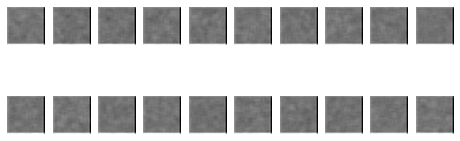

Epoch: 200 [D loss: 2.000190, acc.: 50.50%, op_acc: 48.00%] [G loss: 2.482871]


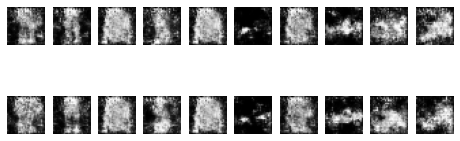

Epoch: 400 [D loss: 1.871403, acc.: 59.50%, op_acc: 42.00%] [G loss: 2.071608]


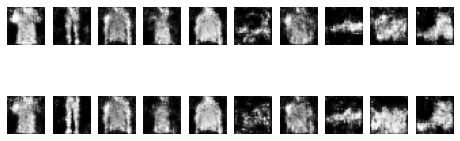

Epoch: 600 [D loss: 1.811063, acc.: 50.00%, op_acc: 47.50%] [G loss: 1.917936]


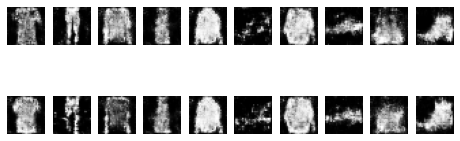

Epoch: 800 [D loss: 1.876017, acc.: 54.00%, op_acc: 41.00%] [G loss: 1.876779]


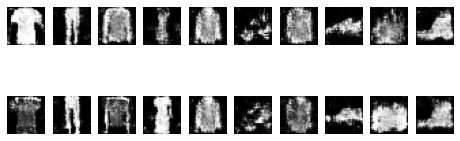

Epoch: 1000 [D loss: 1.931799, acc.: 54.00%, op_acc: 38.50%] [G loss: 1.962133]


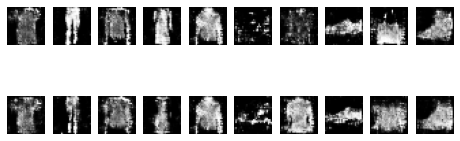

Epoch: 1200 [D loss: 1.872688, acc.: 49.50%, op_acc: 46.00%] [G loss: 1.960614]


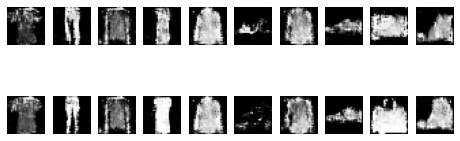

Epoch: 1400 [D loss: 2.022070, acc.: 51.00%, op_acc: 40.50%] [G loss: 1.772044]


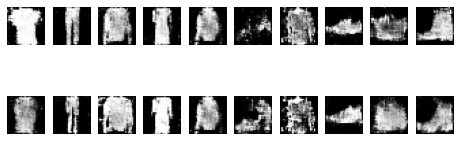

Epoch: 1600 [D loss: 1.248583, acc.: 83.50%, op_acc: 66.50%] [G loss: 1.961113]


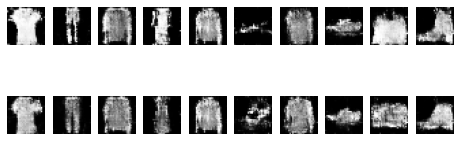

Epoch: 1800 [D loss: 1.715362, acc.: 60.50%, op_acc: 48.00%] [G loss: 1.766383]


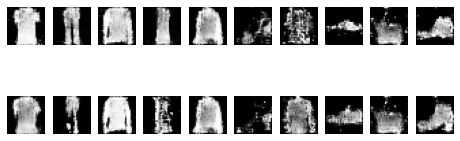

In [ ]:
g_loss, d_loss = ac_gan.train(X_train, y_train, epochs=2000, batch_size=100, sample_interval=200)

### 2.3 Loss evolution

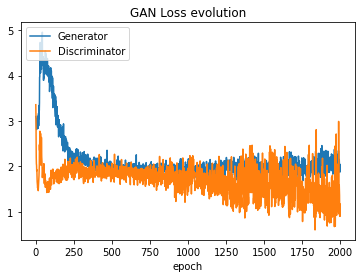

In [ ]:
plot_gan_losses(g_loss, d_loss)

### 2.4 Examples of generated fake images



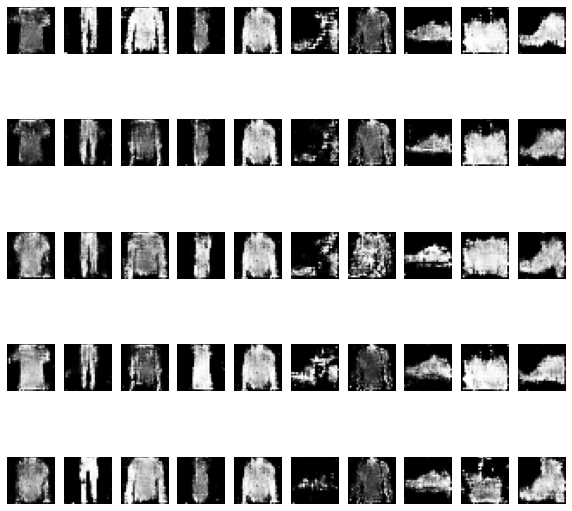

In [ ]:
ac_gan.sample_images(0, smp_rows=5, smp_cols=10, save_img=False, fig_size=(10, 10))

### 2.5 Check if a generated image is a copy of k-nearest neighbors

In [ ]:
id_label_sample = 8
#yet another noise sample
yan = np.random.normal(0, 1, (1, 100))
img_smp = ac_gan.generator.predict([yan, np.array(id_label_sample).reshape(1, )])[0, :, :, 0]
img_smp = img_smp*0.5 + 0.5

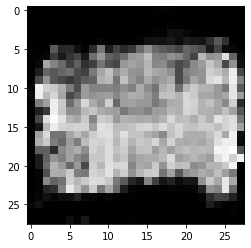

In [ ]:
#original image
plt.imshow(img_smp, cmap='gray')

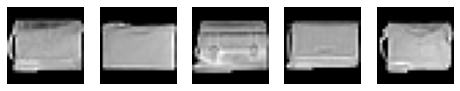

In [ ]:
plot_n_closest(img_smp, 8, X_train, 5, fig_size=(8, 8))

## 3. Application (32x32) : Cifar10

### 3.1 Adapted class of AC-GANs (conv size etc)

In [ ]:
!pip install --upgrade gupload

from pydrive.auth import GoogleAuth
from google.colab import auth

     |████████████████████████████████| 81kB 4.0MB/s 
     |████████████████████████████████| 61kB 7.7MB/s 
  Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
  Found existing installation: google-api-python-client 1.7.12
    Uninstalling google-api-python-client-1.7.12:
      Successfully uninstalled google-api-python-client-1.7.12


In [ ]:
auth.authenticate_user()

In [3]:
def noisy_LeakyReLU_1(x):
  return K.relu(x, alpha=0.2) #+ K.random_normal(shape=tf.shape(x), mean=0, stddev=0.03)

def noisy_LeakyReLU_2(x):
  return K.relu(x, alpha=0.2) + K.random_normal(shape=tf.shape(x), mean=0, stddev=0.2)

def noisy_sigmoid(x):
  return K.sigmoid(x) + K.random_normal(shape=tf.shape(x), mean=0, stddev=0.1)

def noisy_softmax(x):
  return K.softmax(x) + K.random_normal(shape=tf.shape(x), mean=0, stddev=0.1)

def noisy_tanh(x):
  return K.tanh(x) + K.random_normal(shape=tf.shape(x), mean=0, stddev=0.2)

def noisy_ReLU(x):
    return K.relu(x, alpha=0.0) + K.random_normal(shape=tf.shape(x), mean=0, stddev=0.2)


get_custom_objects().update({'noisy_LeakyReLU_1': Activation(noisy_LeakyReLU_1)})
get_custom_objects().update({'noisy_LeakyReLU_2': Activation(noisy_LeakyReLU_2)})
get_custom_objects().update({'noisy_sigmoid': Activation(noisy_sigmoid)})
get_custom_objects().update({'noisy_tanh': Activation(noisy_tanh)})
get_custom_objects().update({'noisy_softmax': Activation(noisy_softmax)})
get_custom_objects().update({'noisy_ReLU': Activation(noisy_ReLU)})

In [88]:
class AcGan_Cifar():
  def __init__(self, nb_rows, nb_columns, nb_channels, nb_classes, noise_dim=110):
    self.input_shape = (nb_rows, nb_columns, nb_channels)
    self.nb_classes = nb_classes
    self.noise_dim = noise_dim
    self.discriminator = Sequential()
    self.generator = Sequential()
    self.model = None
    self.optimizer = Adam(0.0001, 0.5, 0.999)
    self.losses = ['binary_crossentropy', 'sparse_categorical_crossentropy']


  def instanciate_discriminator(self) :
    self.discriminator.add(Conv2D(16, kernel_size=3, strides=2,
                                  input_shape=self.input_shape,
                                  padding="same",
                                  use_bias=True,
                                  bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.0)))
    self.discriminator.add(LeakyReLU(alpha=0.2))
    #self.discriminator.add(Activation('noisy_LeakyReLU_1'))
    self.discriminator.add(Dropout(0.5))

    self.discriminator.add(Conv2D(32, kernel_size=3, strides=1,
                                  padding="same",
                                  use_bias=True,
                                  bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02)))
    self.discriminator.add(ZeroPadding2D(padding=((0,1),(0,1))))
    self.discriminator.add(LeakyReLU(alpha=0.2))
    #self.discriminator.add(Activation('noisy_LeakyReLU_1'))
    self.discriminator.add(Dropout(0.5))
    self.discriminator.add(BatchNormalization(momentum=0.8))

    self.discriminator.add(Conv2D(64, kernel_size=3, strides=2,
                                  padding="same",
                                  use_bias=True,
                                  bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02)))
    self.discriminator.add(LeakyReLU(alpha=0.2))
    #self.discriminator.add(Activation('noisy_LeakyReLU_1'))
    self.discriminator.add(Dropout(0.5))
    self.discriminator.add(BatchNormalization(momentum=0.8))

    self.discriminator.add(Conv2D(128, kernel_size=3, strides=1,
                                  padding="same",
                                  use_bias=True,
                                  bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02)))
    self.discriminator.add(LeakyReLU(alpha=0.2))
    #self.discriminator.add(Activation('noisy_LeakyReLU_1'))
    self.discriminator.add(Dropout(0.5))
    self.discriminator.add(BatchNormalization(momentum=0.8))

    self.discriminator.add(Conv2D(256, kernel_size=3, strides=2,
                                  padding="same",
                                  use_bias=True,
                                  bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02)))
    self.discriminator.add(LeakyReLU(alpha=0.2))
    #self.discriminator.add(Activation('noisy_LeakyReLU_1'))
    self.discriminator.add(Dropout(0.5))
    self.discriminator.add(BatchNormalization(momentum=0.8))

    self.discriminator.add(Conv2D(512, kernel_size=3, strides=1,
                                  padding="same",
                                  use_bias=True,
                                  bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.0)))
    self.discriminator.add(LeakyReLU(alpha=0.2))
    #self.discriminator.add(Activation('noisy_LeakyReLU_1'))
    self.discriminator.add(Dropout(0.5))
    self.discriminator.add(BatchNormalization(momentum=0.8))

    self.discriminator.add(Flatten())
    self.discriminator.summary()

    # Extract feature representation
    img_real = Input(shape=self.input_shape)
    features = self.discriminator(img_real)

    # Determine validity and label of the image
    validity = Dense(1, activation="sigmoid",
                      bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
                      kernel_regularizer=keras.regularizers.l2(0.001)
                      )(features)
    label = Dense(self.nb_classes+1, activation="softmax",
                      bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
                      kernel_regularizer=keras.regularizers.l2(0.001)
                      )(features)

    self.discriminator = Model(img_real, [validity, label])
    self.discriminator.compile(loss=self.losses,
      optimizer=self.optimizer) # , metrics=['accuracy']

    self.discriminator.summary()


  def instanciate_generator(self):
    self.generator.add(Dense(24 * 4 * 4, activation="relu", input_dim=self.noise_dim))
    self.generator.add(Reshape((4, 4, 24)))
    #self.generator.add(BatchNormalization(momentum=0.8))
    #self.generator.add(UpSampling2D())

    self.generator.add(Conv2DTranspose(192, kernel_size=5, strides=2, padding="same"))
    self.generator.add(Activation("relu"))
    self.generator.add(BatchNormalization(momentum=0.8))
    #self.generator.add(UpSampling2D())

    self.generator.add(Conv2DTranspose(96, kernel_size=5, strides=2, padding="same"))
    self.generator.add(Activation("relu"))
    self.generator.add(BatchNormalization(momentum=0.8))

    self.generator.add(Conv2DTranspose(self.input_shape[2], kernel_size=5, strides=2, padding='same'))
    self.generator.add(Activation("tanh"))

    self.generator.summary()

    noise = Input(shape=(self.noise_dim,))
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Flatten()(Embedding(self.nb_classes, self.noise_dim)(label))

    model_input = multiply([noise, label_embedding])
    img_gen = self.generator(model_input)

    self.generator = Model([noise, label], img_gen)
    self.generator.summary()


  def instanciate_combined_model(self):
    # The generator takes noise and the target label as input and generates the corresponding digit of that label
    noise = Input(shape=(self.noise_dim,))
    label = Input(shape=(1,), dtype='int32')
    img_gen = self.generator([noise, label])

    # For the combined model we will only train the generator
    self.discriminator.trainable = False

    # The discriminator takes generated image as input and determines validity and the label of that image
    valid, target_label = self.discriminator(img_gen)

    # The combined model  (stacked generator and discriminator) trains the generator to fool the discriminator
    self.model = Model([noise, label], [valid, target_label])
    self.model.compile(loss=self.losses,
        optimizer=self.optimizer)


    def save(model, model_name):
      model_path = "../saved_model/%s.json" % model_name
      weights_path = "../saved_model/%s_weights.hdf5" % model_name
      options = {"file_arch": model_path,
                  "file_weight": weights_path}
      json_string = model.to_json()
      open(options['file_arch'], 'w').write(json_string)
      model.save_weights(options['file_weight'])

      #save(self.generator, "generator")
      #save(self.discriminator, "discriminator")



  def train(self, X_train, y_train, epochs, batch_size=100, sample_interval=50):
    # Configure inputs
    X_train = ( X_train.astype(np.float32) - 127.5) / 127.5
    #X_train = np.expand_dims(X_train, axis=4)
    y_train = y_train.reshape(-1, 1)

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    # Loss output
    g_loss_epochs = np.zeros((epochs, 1))
    d_loss_epochs = np.zeros((epochs, 1))

    for epoch in range(epochs):
        # ---------------------
        #  Train Discriminator
        # ---------------------
        # Select a random batch of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Sample noise as generator input
        noise = np.random.normal(0, 1, (batch_size, self.noise_dim))

        # The labels of the digits that the generator tries to create an
        # image representation of
        sampled_labels = np.random.randint(0, self.nb_classes, (batch_size, 1))

        # Generate a half batch of new images
        gen_imgs = self.generator.predict([noise, sampled_labels])

        # Image labels. 0-9 if image is valid or 10 if it is generated (fake)
        img_labels = y_train[idx]
        fake_labels = self.nb_classes * np.ones(img_labels.shape)


        # Train the discriminator

        # mélanger les Set de imgs et gen_imgs, garder les index, et assigner les bons labels, train en 1 fois
        #d_loss_real = self.discriminator.train_on_batch(imgs, [valid, img_labels])
        #d_loss_fake = self.discriminator.train_on_batch(gen_imgs, [fake, fake_labels])
        #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        all_imgs = np.concatenate((imgs, gen_imgs))
        all_sources = np.concatenate((valid, fake))
        all_labels = np.concatenate((img_labels, fake_labels))
        indices = np.indices((2*batch_size,))[0]
        np.random.shuffle(indices)
        d_loss = self.discriminator.train_on_batch(all_imgs[indices], [all_sources[indices], all_labels[indices]])

        # ---------------------
        #  Train Generator
        # ---------------------
        g_loss = self.model.train_on_batch([noise, sampled_labels], [valid, sampled_labels])

        #show the final losses
        g_loss_epochs[epoch] = g_loss[0]
        d_loss_epochs[epoch] = d_loss[0]

        # If at save interval => save generated image samples
        if epoch % sample_interval == 0:
            # Plot the progress
            print ("Epoch: %d [D loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss[0]))
            # , acc.: %.2f%%, op_acc: %.2f%%
            # , 100*d_loss[3], 100*d_loss[4]
            #do not save model
            #self.save_model()
            self.model.save('acgan.h5')
            # !gupload --to '1ZKgg7ho7h-9ONXg0bVsNcwl4GzpOJqry' acgan.h5
            self.sample_images(epoch, smp_rows=2, smp_cols=10, save_img=False)

    return g_loss_epochs, d_loss_epochs




  #row, cols to be sampled
  def sample_images(self, epoch, smp_rows=5, smp_cols=10, save_img=True, fig_size=(8, 3)):
      r, c = smp_rows, smp_cols
      noise = np.random.normal(0, 1, (r * c, self.noise_dim))
      sampled_labels = np.array([num for _ in range(r) for num in range(c)])
      gen_imgs = self.generator.predict((noise, sampled_labels))
      # Rescale images 0 - 1
      gen_imgs = 0.5 * gen_imgs + 0.5
      #gen_ims = (gen_imgs * 127.5) + 127.5

      #plt.figure(figsize=fig_size)
      fig, axs = plt.subplots(r, c, figsize=fig_size)
      cnt = 0
      for i in range(r):
          for j in range(c):
              axs[i,j].imshow(gen_imgs[cnt,:,:,:]) #, cmap='gray')
              axs[i,j].axis('off')
              cnt += 1
      if save_img:
          fig.savefig("../images/%d.png" % epoch)
      else:
          #plt.figure(figsize=fig_size)
          plt.show()
      plt.close()



  def sample_single_image(self, noise, label):
      gen_imgs = self.generator.predict([noise, np.array(label).reshape((1, ))])
      # Rescale images 0 - 1
      gen_imgs = 0.5 * gen_imgs + 0.5
      #gen_ims = (gen_imgs * 127.5) + 127.5
      plt.imshow(gen_imgs[0, :, :, :]) #, cmap='gray')

### 3.2 Application

In [20]:
(X_train, y_train), (_, _) = cifar10.load_data()

In [21]:
label_dict = {0: 'cat',
              1: 'dog',
              2: 'horse',
              3: 'car',
              4: 'truck',
              5: 'plane',
              6: 'frog',
              7: 'bird',
              8: 'boat',
              9: 'deer'}

In [7]:
len(label_dict)

10

In [8]:
X_train.shape

(50000, 32, 32, 3)

In [9]:
X_train[0].shape

(32, 32, 3)

In [10]:
y_train.shape

(50000, 1)

In [89]:
ac_gan = AcGan_Cifar(nb_rows=32, nb_columns=32, nb_channels=3, nb_classes=len(label_dict), noise_dim=110)

In [90]:
ac_gan.instanciate_discriminator()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_66 (Conv2D)              │ (None, 16, 16, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_66 (LeakyReLU)      │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_11               │ (None, 17, 17, 32)     │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_67 (LeakyReLU)      │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_77          │ (None, 17, 17, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 9, 9, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_68 (LeakyReLU)      │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_78          │ (None, 9, 9, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 9, 9, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_69 (LeakyReLU)      │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_79          │ (None, 9, 9, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ (None, 5, 5, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_70 (LeakyReLU)      │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_80          │ (None, 5, 5, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 5, 5, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_71 (LeakyReLU)      │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,576,736 (6.01 MB)

 Trainable params: 1,574,752 (6.01 MB)

 Non-trainable params: 1,984 (7.75 KB)

Model: "functional_432"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_75      │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_24       │ (None, 12800)     │  1,576,736 │ input_layer_75[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 1)         │     12,801 │ sequential_24[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 11)        │    140,811 │ sequential_24[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,730,348 (6.60 MB)

 Trainable params: 1,728,364 (6.59 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [91]:
ac_gan.instanciate_generator()

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_35 (Dense)                │ (None, 384)            │        42,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_11 (Reshape)            │ (None, 4, 4, 24)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_33             │ (None, 8, 8, 192)      │       115,392 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_39 (Activation)      │ (None, 8, 8, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_82          │ (None, 8, 8, 192)      │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_34             │ (None, 16, 16, 96)     │       460,896 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_40 (Activation)      │ (None, 16, 16, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_83          │ (None, 16, 16, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_35             │ (None, 32, 32, 3)      │         7,203 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_41 (Activation)      │ (None, 32, 32, 3)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 627,267 (2.39 MB)

 Trainable params: 626,691 (2.39 MB)

 Non-trainable params: 576 (2.25 KB)

Model: "functional_443"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_78      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_11        │ (None, 1, 110)    │      1,100 │ input_layer_78[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_77      │ (None, 110)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_23          │ (None, 110)       │          0 │ embedding_11[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_11         │ (None, 110)       │          0 │ input_layer_77[0… │
│ (Multiply)          │                   │            │ flatten_23[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_25       │ (None, 32, 32, 3) │    627,267 │ multiply_11[0][0] │
│ (Sequential)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 628,367 (2.40 MB)

 Trainable params: 627,791 (2.39 MB)

 Non-trainable params: 576 (2.25 KB)

In [92]:
ac_gan.instanciate_combined_model()

#### test

In [43]:
ac_gan.model.load_weights('acgan.h5')

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'acgan.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [93]:
g_loss, d_loss = ac_gan.train(X_train, y_train, epochs=50001, batch_size=1000, sample_interval=200)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


Epoch: 0 [D loss: 3.092498] [G loss: 3.110535]


ValueError: as_list() is not defined on an unknown TensorShape.

In [98]:
from __future__ import print_function, division

import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Conv2D, UpSampling2D, concatenate, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

from keras.datasets import mnist, fashion_mnist, cifar10
# import cifar10
import tensorflow_datasets as tfds

from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Activation
from keras import backend as K
from tensorflow.keras.utils import get_custom_objects

import pandas as pd

from math import floor
from numpy import ones, expand_dims, log, mean, std, exp, asarray

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from skimage.transform import resize

from random import shuffle

# from chainer import serializers, datasets
# import cifar
# from inception_score import Inception, inception_score


def noisy_LeakyReLU_1(x):
  return K.relu(x, alpha=0.2) #+ K.random_normal(shape=tf.shape(x), mean=0, stddev=0.03)

def noisy_LeakyReLU_2(x):
  return K.relu(x, alpha=0.2) + K.random_normal(shape=tf.shape(x), mean=0, stddev=0.2)

def noisy_sigmoid(x):
  return K.sigmoid(x) + K.random_normal(shape=tf.shape(x), mean=0, stddev=0.1)

def noisy_softmax(x):
  return K.softmax(x) + K.random_normal(shape=tf.shape(x), mean=0, stddev=0.1)

def noisy_tanh(x):
  return K.tanh(x) + K.random_normal(shape=tf.shape(x), mean=0, stddev=0.2)

def noisy_ReLU(x):
    return K.relu(x, alpha=0.0) + K.random_normal(shape=tf.shape(x), mean=0, stddev=0.2)


get_custom_objects().update({'noisy_LeakyReLU_1': Activation(noisy_LeakyReLU_1)})
get_custom_objects().update({'noisy_LeakyReLU_2': Activation(noisy_LeakyReLU_2)})
get_custom_objects().update({'noisy_sigmoid': Activation(noisy_sigmoid)})
get_custom_objects().update({'noisy_tanh': Activation(noisy_tanh)})
get_custom_objects().update({'noisy_softmax': Activation(noisy_softmax)})
get_custom_objects().update({'noisy_ReLU': Activation(noisy_ReLU)})

class AcGan_Cifar():
    def __init__(self, nb_rows, nb_columns, nb_channels, nb_classes, noise_dim=110):
        self.input_shape = (nb_rows, nb_columns, nb_channels)
        self.nb_classes = nb_classes
        self.noise_dim = noise_dim
        self.discriminator = Sequential()
        self.generator = Sequential()
        self.model = None
        self.optimizer = Adam(0.0001, 0.5, 0.999)
        self.losses = ['binary_crossentropy', 'sparse_categorical_crossentropy']

    def instanciate_discriminator(self):
        self.discriminator.add(Conv2D(16, kernel_size=3, strides=2,
                                      input_shape=self.input_shape,
                                      padding="same",
                                      use_bias=True,
                                      bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.0)))
        self.discriminator.add(LeakyReLU(alpha=0.2))
        # self.discriminator.add(Activation('noisy_LeakyReLU_1'))
        self.discriminator.add(Dropout(0.5))

        self.discriminator.add(Conv2D(32, kernel_size=3, strides=1,
                                      padding="same",
                                      use_bias=True,
                                      bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02)))
        self.discriminator.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
        self.discriminator.add(LeakyReLU(alpha=0.2))
        # self.discriminator.add(Activation('noisy_LeakyReLU_1'))
        self.discriminator.add(Dropout(0.5))
        self.discriminator.add(BatchNormalization(momentum=0.8))

        self.discriminator.add(Conv2D(64, kernel_size=3, strides=2,
                                      padding="same",
                                      use_bias=True,
                                      bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02)))
        self.discriminator.add(LeakyReLU(alpha=0.2))
        # self.discriminator.add(Activation('noisy_LeakyReLU_1'))
        self.discriminator.add(Dropout(0.5))
        self.discriminator.add(BatchNormalization(momentum=0.8))

        self.discriminator.add(Conv2D(128, kernel_size=3, strides=1,
                                      padding="same",
                                      use_bias=True,
                                      bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02)))
        self.discriminator.add(LeakyReLU(alpha=0.2))
        # self.discriminator.add(Activation('noisy_LeakyReLU_1'))
        self.discriminator.add(Dropout(0.5))
        self.discriminator.add(BatchNormalization(momentum=0.8))

        self.discriminator.add(Conv2D(256, kernel_size=3, strides=2,
                                      padding="same",
                                      use_bias=True,
                                      bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02)))
        self.discriminator.add(LeakyReLU(alpha=0.2))
        # self.discriminator.add(Activation('noisy_LeakyReLU_1'))
        self.discriminator.add(Dropout(0.5))
        self.discriminator.add(BatchNormalization(momentum=0.8))

        self.discriminator.add(Conv2D(512, kernel_size=3, strides=1,
                                      padding="same",
                                      use_bias=True,
                                      bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.0)))
        self.discriminator.add(LeakyReLU(alpha=0.2))
        # self.discriminator.add(Activation('noisy_LeakyReLU_1'))
        self.discriminator.add(Dropout(0.5))
        self.discriminator.add(BatchNormalization(momentum=0.8))

        self.discriminator.add(Flatten())
        self.discriminator.summary()

        # Extract feature representation
        img_real = Input(shape=self.input_shape)
        features = self.discriminator(img_real)

        # Determine validity and label of the image
        validity = Dense(1, activation="sigmoid",
                         bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
                         kernel_regularizer=keras.regularizers.l2(0.001)
                         )(features)
        label = Dense(self.nb_classes + 1, activation="softmax",
                      bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
                      kernel_regularizer=keras.regularizers.l2(0.001)
                      )(features)

        self.discriminator = Model(img_real, [validity, label])
        self.discriminator.compile(loss=self.losses,
                                   optimizer=self.optimizer,
                                   metrics=['accuracy'])

        self.discriminator.summary()

    def instanciate_generator(self):
        self.generator.add(Dense(24 * 4 * 4, activation="relu", input_dim=self.noise_dim))
        self.generator.add(Reshape((4, 4, 24)))
        # self.generator.add(BatchNormalization(momentum=0.8))
        # self.generator.add(UpSampling2D())

        self.generator.add(Conv2DTranspose(192, kernel_size=5, strides=2, padding="same"))
        self.generator.add(Activation("relu"))
        self.generator.add(BatchNormalization(momentum=0.8))
        # self.generator.add(UpSampling2D())

        self.generator.add(Conv2DTranspose(96, kernel_size=5, strides=2, padding="same"))
        self.generator.add(Activation("relu"))
        self.generator.add(BatchNormalization(momentum=0.8))

        self.generator.add(Conv2DTranspose(self.input_shape[2], kernel_size=5, strides=2, padding='same'))
        self.generator.add(Activation("tanh"))

        self.generator.summary()

        noise = Input(shape=(self.noise_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.nb_classes, self.noise_dim)(label))

        model_input = multiply([noise, label_embedding])
        img_gen = self.generator(model_input)

        self.generator = Model([noise, label], img_gen)
        self.generator.summary()

    def instanciate_combined_model(self):
        # The generator takes noise and the target label as input and generates the corresponding digit of that label
        noise = Input(shape=(self.noise_dim,))
        label = Input(shape=(1,), dtype='int32')
        img_gen = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity and the label of that image
        valid, target_label = self.discriminator(img_gen)

        # The combined model  (stacked generator and discriminator) trains the generator to fool the discriminator
        self.model = Model([noise, label], [valid, target_label])
        self.model.compile(loss=self.losses,
                           optimizer=self.optimizer)

        def save(model, model_name):
            model_path = "../saved_model/%s.json" % model_name
            weights_path = "../saved_model/%s_weights.hdf5" % model_name
            options = {"file_arch": model_path,
                       "file_weight": weights_path}
            json_string = model.to_json()
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])

            # save(self.generator, "generator")
            # save(self.discriminator, "discriminator")

    def train(self, X_train, y_train, epochs, batch_size=100, sample_interval=50):
        # Configure inputs
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        # X_train = np.expand_dims(X_train, axis=4)
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        # Loss output
        g_loss_epochs = np.zeros((epochs, 1))
        d_loss_epochs = np.zeros((epochs, 1))

        for epoch in range(epochs):
            print(epoch)
            # ---------------------
            #  Train Discriminator
            # ---------------------
            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, self.noise_dim))

            # The labels of the digits that the generator tries to create an
            # image representation of
            sampled_labels = np.random.randint(0, self.nb_classes, (batch_size, 1))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, sampled_labels])

            # Image labels. 0-9 if image is valid or 10 if it is generated (fake)
            img_labels = y_train[idx]
            fake_labels = self.nb_classes * np.ones(img_labels.shape)

            # Train the discriminator

            # mélanger les Set de imgs et gen_imgs, garder les index, et assigner les bons labels, train en 1 fois
            # d_loss_real = self.discriminator.train_on_batch(imgs, [valid, img_labels])
            # d_loss_fake = self.discriminator.train_on_batch(gen_imgs, [fake, fake_labels])
            # d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            all_imgs = np.concatenate((imgs, gen_imgs))
            all_sources = np.concatenate((valid, fake))
            all_labels = np.concatenate((img_labels, fake_labels))
            indices = np.indices((2 * batch_size,))[0]
            np.random.shuffle(indices)
            d_loss = self.discriminator.train_on_batch(all_imgs[indices], [all_sources[indices], all_labels[indices]])

            # ---------------------
            #  Train Generator
            # ---------------------
            g_loss = self.model.train_on_batch([noise, sampled_labels], [valid, sampled_labels])

            # show the final losses
            g_loss_epochs[epoch] = g_loss[0]
            d_loss_epochs[epoch] = d_loss[0]

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                # Plot the progress
                print("Epoch: %d [D loss: %f, acc.: %.2f%%, op_acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0],
                                                                                             100 * d_loss[3],
                                                                                             100 * d_loss[4],
                                                                                             g_loss[0]))
                # do not save model
                # self.save_model()
                self.model.save('acgan.h5')
                self.sample_images(epoch, smp_rows=2, smp_cols=10, save_img=False)

        return g_loss_epochs, d_loss_epochs

    # row, cols to be sampled
    def sample_images(self, epoch, smp_rows=5, smp_cols=10, save_img=True, fig_size=(8, 3)):
        r, c = smp_rows, smp_cols
        noise = np.random.normal(0, 1, (r * c, self.noise_dim))
        sampled_labels = np.array([num for _ in range(r) for num in range(c)])
        gen_imgs = self.generator.predict([noise, sampled_labels])
        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        # gen_ims = (gen_imgs * 127.5) + 127.5

        # plt.figure(figsize=fig_size)
        fig, axs = plt.subplots(r, c, figsize=fig_size)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, :])  # , cmap='gray')
                axs[i, j].axis('off')
                cnt += 1
        if save_img:
            fig.savefig("../images/%d.png" % epoch)
        else:
            # plt.figure(figsize=fig_size)
            plt.show()
        plt.close()

    def sample_single_image(self, noise, label):
        gen_imgs = self.generator.predict([noise, np.array(label).reshape((1,))])
        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        # gen_ims = (gen_imgs * 127.5) + 127.5
        plt.imshow(gen_imgs[0, :, :, :])  # , cmap='gray')

def plot_gan_losses(g_loss, d_loss):
    plt.plot(g_loss)
    plt.plot(d_loss)
    plt.title('GAN Loss evolution')
    plt.ylabel('')
    plt.xlabel('epoch')
    plt.legend(['Generator', 'Discriminator'], loc='upper left')
    plt.show()

if __name__ == '__main__':
    (X_train, y_train), (_, _) = cifar10.load_data()
    label_dict = {0: 'cat',
                  1: 'dog',
                  2: 'horse',
                  3: 'car',
                  4: 'truck',
                  5: 'plane',
                  6: 'frog',
                  7: 'bird',
                  8: 'boat',
                  9: 'deer'}

    ac_gan = AcGan_Cifar(nb_rows=32, nb_columns=32, nb_channels=3, nb_classes=len(label_dict), noise_dim=110)
    ac_gan.instanciate_discriminator()
    ac_gan.instanciate_generator()
    ac_gan.instanciate_combined_model()
    # ac_gan.model.load_weights('acgan.h5')
    g_loss, d_loss = ac_gan.train(X_train, y_train, epochs=50001, batch_size=1000, sample_interval=200)
    plot_gan_losses(g_loss, d_loss)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_72 (Conv2D)              │ (None, 16, 16, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_72 (LeakyReLU)      │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_12               │ (None, 17, 17, 32)     │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_73 (LeakyReLU)      │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_84          │ (None, 17, 17, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 9, 9, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_74 (LeakyReLU)      │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_85          │ (None, 9, 9, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_75 (Conv2D)              │ (None, 9, 9, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_75 (LeakyReLU)      │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_86          │ (None, 9, 9, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, 5, 5, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_76 (LeakyReLU)      │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_76 (Dropout)            │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_87          │ (None, 5, 5, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 5, 5, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_77 (LeakyReLU)      │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,576,736 (6.01 MB)

 Trainable params: 1,574,752 (6.01 MB)

 Non-trainable params: 1,984 (7.75 KB)

Model: "functional_470"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_82      │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_28       │ (None, 12800)     │  1,576,736 │ input_layer_82[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 1)         │     12,801 │ sequential_28[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 11)        │    140,811 │ sequential_28[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,730,348 (6.60 MB)

 Trainable params: 1,728,364 (6.59 MB)

 Non-trainable params: 1,984 (7.75 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_38 (Dense)                │ (None, 384)            │        42,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_12 (Reshape)            │ (None, 4, 4, 24)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_36             │ (None, 8, 8, 192)      │       115,392 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_54 (Activation)      │ (None, 8, 8, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_89          │ (None, 8, 8, 192)      │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_37             │ (None, 16, 16, 96)     │       460,896 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_55 (Activation)      │ (None, 16, 16, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_90          │ (None, 16, 16, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_38             │ (None, 32, 32, 3)      │         7,203 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_56 (Activation)      │ (None, 32, 32, 3)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 627,267 (2.39 MB)

 Trainable params: 626,691 (2.39 MB)

 Non-trainable params: 576 (2.25 KB)

Model: "functional_481"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_85      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_12        │ (None, 1, 110)    │      1,100 │ input_layer_85[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_84      │ (None, 110)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_25          │ (None, 110)       │          0 │ embedding_12[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_12         │ (None, 110)       │          0 │ input_layer_84[0… │
│ (Multiply)          │                   │            │ flatten_25[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_29       │ (None, 32, 32, 3) │    627,267 │ multiply_12[0][0] │
│ (Sequential)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 628,367 (2.40 MB)

 Trainable params: 627,791 (2.39 MB)

 Non-trainable params: 576 (2.25 KB)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


ValueError: For a model with multiple outputs, when providing the `metrics` argument as a list, it should have as many entries as the model has outputs. Received:
metrics=['accuracy']
of length 1 whereas the model has 2 outputs.